In [1]:
import census_pdf_parser

files= [
    'data/Addis_Ababa_Statistical-table_3.1.pdf',
    'data/Affar_Statistical-table_3.1.pdf',
    'data/Statistical_Amhara-table_3.1.pdf',
    'data/Benishangu_Gumuz_Statistical-table_3.1.pdf',
    'data/Dire_Dawa_Statistical-table_3.1.pdf',
    'data/Gambella_Statistical-table_3.1.pdf',
    'data/Harari_Statistical-table_3.1.pdf',
    'data/Statistical_Oromiya-table_3.1.pdf',
    'data/Statistical_SNNPR-table_3.1.pdf',
    'data/Somali_Statistical-table_3.1.pdf',
    'data/Tigray_Statistical-table_3.1.pdf',
]
 
tables = {}

for filename in files:
    for name, table in census_pdf_parser.process_file(filename):
        if name in tables:
            name += '~'
        tables[name] = table

print(len(files), 'files.', len(tables), 'tables.' )

11 files. 104 tables.


In [2]:
def joint(v):
    p = sum([vi*vi for vi in v])
    s = v.sum()
    return p/(s*s)

In [3]:
import pandas as pd

df = pd.DataFrame(columns=['name', 'joint', 'population'])

for name,t in tables.items(): 
    if not name:
        continue
    v = t.loc[t.index!='All Groups'][1].dropna()
    df = df.append([{'name': name, 'joint': joint(v), 'population': v.sum()}], 
                   ignore_index=True)

In [4]:
df.loc[df.name == 'Addis_Ababa_Statistical-table_3.1']

,name,joint,population
0,Addis_Ababa_Statistical-table_3.1,0.290171,2744942.0


In [5]:
from regions import region_mapping

rdf = pd.DataFrame(data=region_mapping.items(), 
                   columns=['name', 'region_id'])
df = df.merge(rdf, how='left', on='name')

In [6]:
df.dropna(subset=['region_id']).sort_values(by='population')

,name,joint,population,region_id
29,ARGOBA SPECIAL ZONE,0.915778,34998.0,142802.0
41,ETANG SPECIAL WEREDA,0.478155,35686.0,114974.0
78,BURJI SPECIAL WEREDA,0.912871,55681.0,142823.0
82,BASKETO SPECIAL WEREDA,0.773710,56689.0,114996.0
40,MEZHENGER ZONE,0.187407,59248.0,142805.0
...,...,...,...,...
51,ARSI ZONE,0.721531,2650433.0,114977.0
53,EAST HARARGE ZONE,0.921616,2736759.0,114980.0
0,Addis_Ababa_Statistical-table_3.1,0.290171,2744942.0,10918.0
18,NORTH GONDAR ZONE,0.950543,2939948.0,114962.0


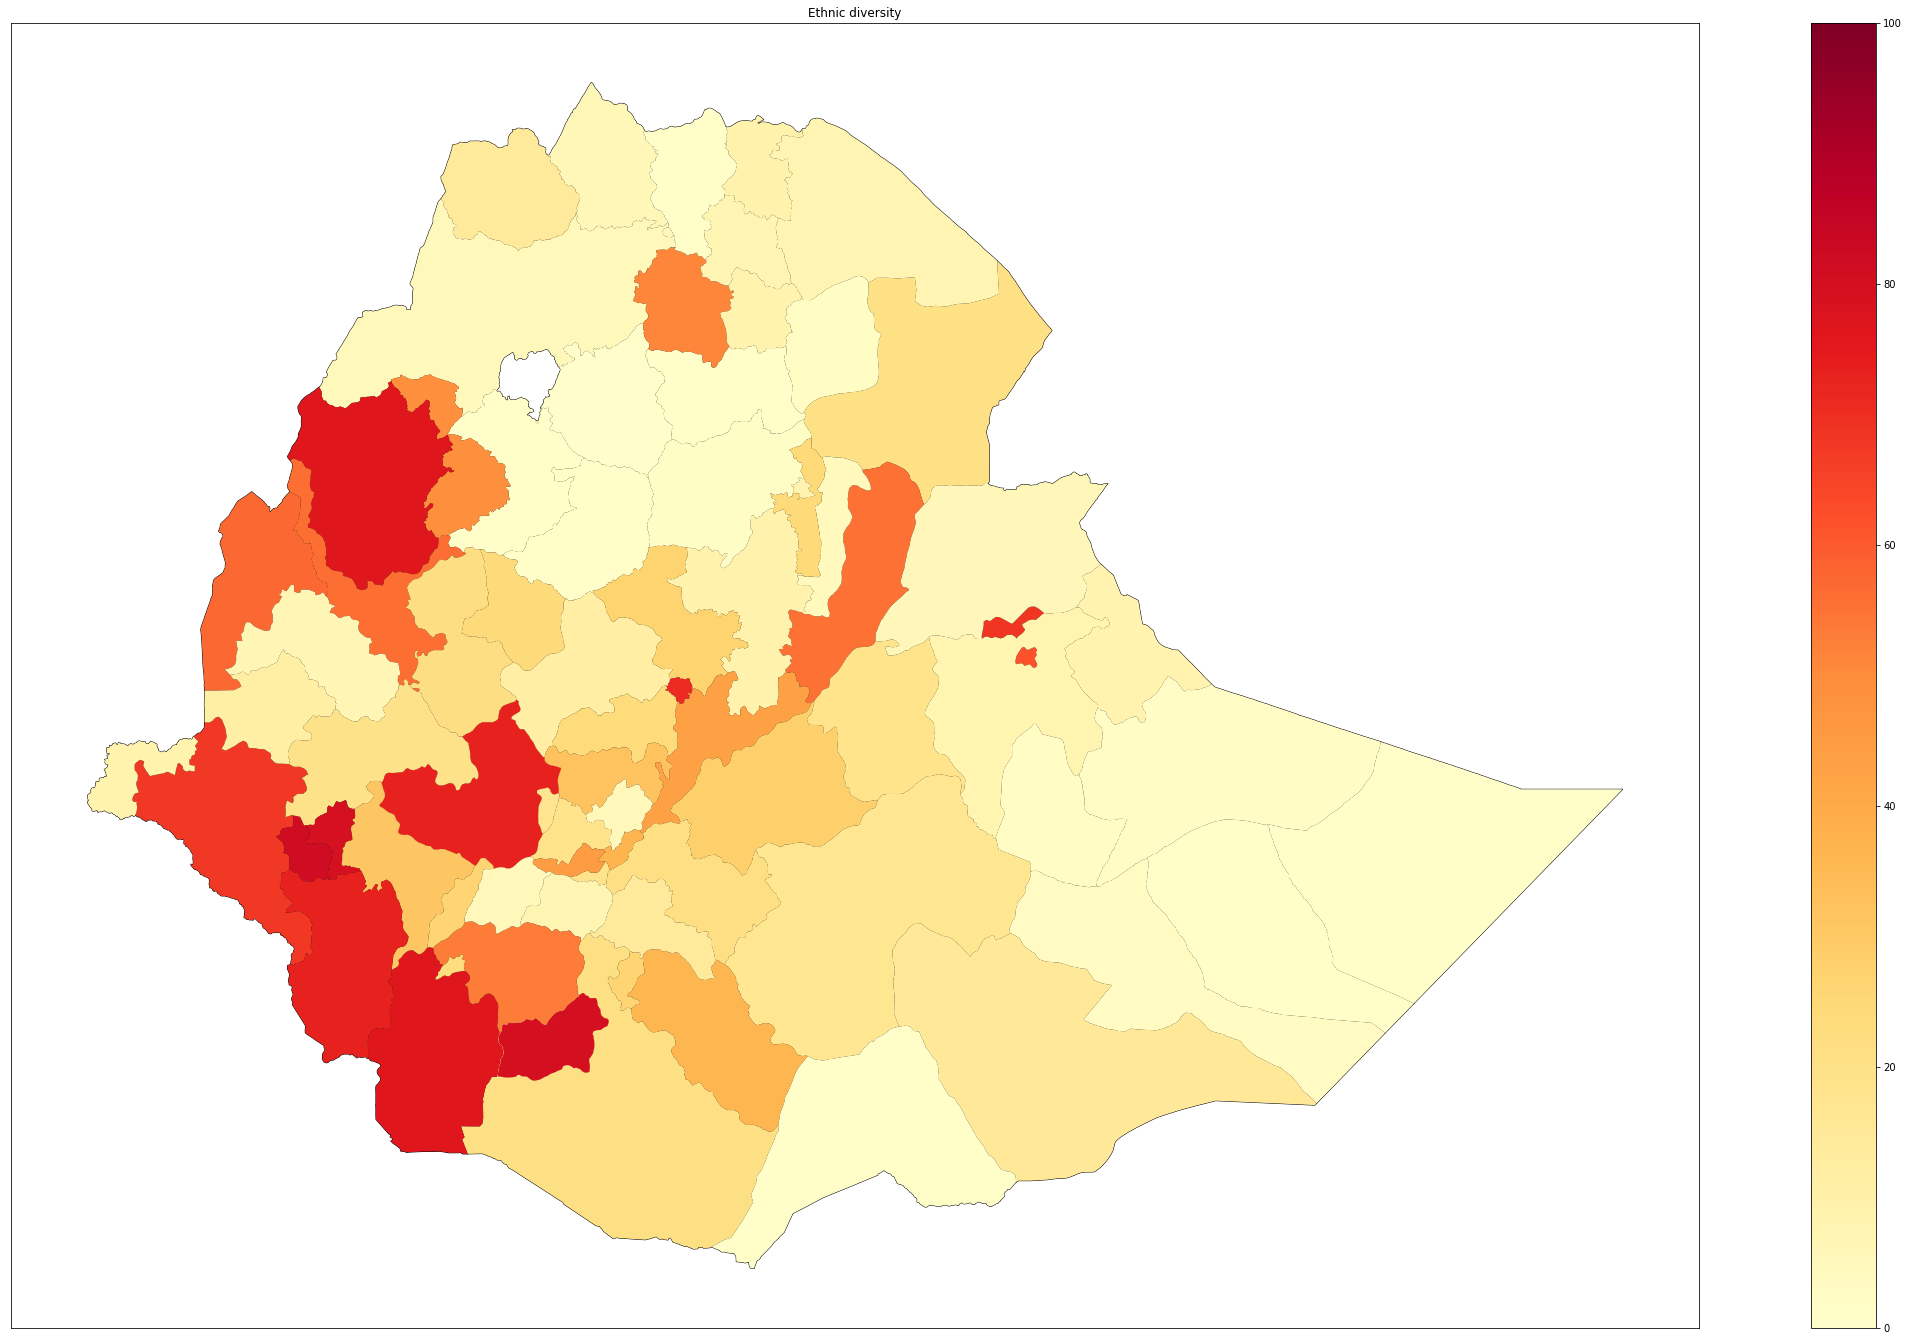

In [7]:
import os
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import shape
from groclient.client import GroClient


client = GroClient('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])
geo_data = []

for r in df[['region_id', 'joint', 'population']].values:
    if pd.isna(r[0]):
        continue
    geom = client.get_geojson(r[0])
    if not geom:
        continue
    geo_data.append({
        'region_id': int(r[0]),
        'geometry': shape(geom['geometries'][0]),
        'diversity': 100*(1.0 - r[1]),
        'population': r[2]
    })

gdf = geopandas.GeoDataFrame(geo_data)

fig, axes = plt.subplots(1, 1, figsize=(40,24))
gdf.plot(ax=axes, edgecolor='black', facecolor='lightgray')
gdf.plot(column='diversity',  cmap='YlOrRd', vmin=0, vmax=100, 
         ax=axes, legend=True)
axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
axes.set_title('Ethnic diversity')
plt.show()

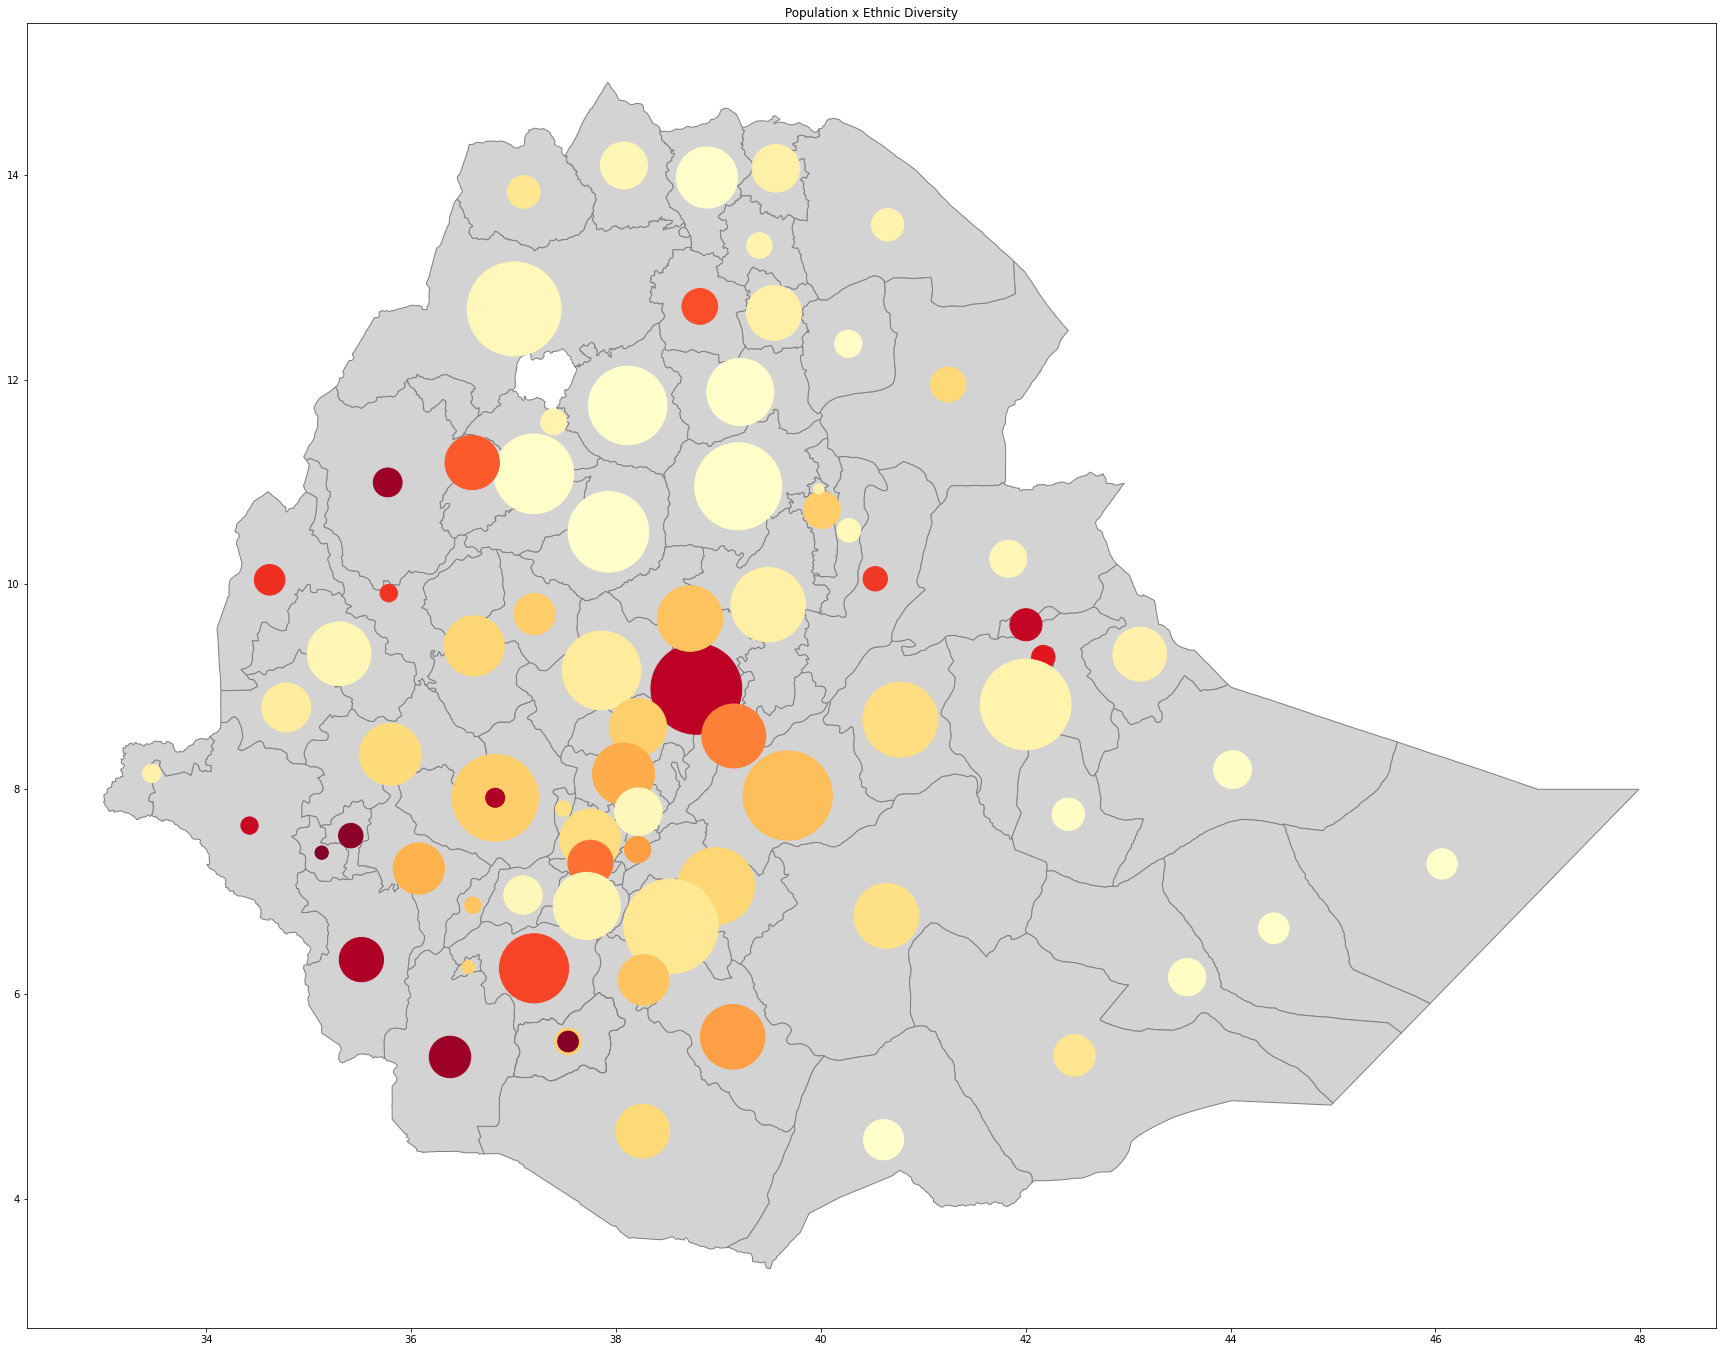

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(40,24))
gdf.plot(ax=axes, edgecolor='gray', facecolor='lightgray')
plt.scatter(list(map(lambda p: p.x, gdf.centroid)), 
            list(map(lambda p: p.y, gdf.centroid)), 
            c=gdf['diversity'], cmap='YlOrRd', 
            s=gdf['population']/333)
axes.set_title('Population x Ethnic Diversity')
plt.show()